In [1]:
cd drive/MyDrive/


/content/drive/MyDrive


In [2]:
cd KHDL_IT4930/model/

/content/drive/MyDrive/KHDL_IT4930/model


In [ ]:
ls

ANN.ipynb  predict_car_prices_use_knn.ipynb  Regression.ipynb


In [3]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
cars = pd.read_csv('../dataset/data.csv', error_bad_lines=False, delimiter='\t')
print(cars.shape)
cars.head()

(53689, 12)


,Unnamed: 0,kieu_dang,hop_so,km_da_di,nhien_lieu,so_cho_ngoi,tinh_trang,xuat_xu,nam_sx,gia,dong_xe,hang
0,0,Sedan,Tự động,9000,Xăng,5,Đã sử dụng,Lắp ráp trong nước,2019,4480000000,Sclass,Mercedes Benz
1,1,Sedan,Tự động,20000,Xăng,5,Đã sử dụng,Lắp ráp trong nước,2017,1155000000,Cclass,Mercedes Benz
2,2,SUV / Cross over,Tự động,0,Xăng,5,Mới,Lắp ráp trong nước,2021,579000000,Kona,Hyundai
3,3,SUV / Cross over,Tự động,0,Xăng,5,Mới,Lắp ráp trong nước,2021,825000000,Tucson,Hyundai
4,4,Sedan,Tự động,32000,Xăng,4,Đã sử dụng,Nhập khẩu,2017,5750000000,Panamera,Porsche


In [5]:
cars.hop_so.unique()

array(['Tự động', 'Số tay', 'Số sàn', 'Bán tự động'], dtype=object)

In [6]:
cars.dtypes

Unnamed: 0      int64
kieu_dang      object
hop_so         object
km_da_di        int64
nhien_lieu     object
so_cho_ngoi     int64
tinh_trang     object
xuat_xu        object
nam_sx          int64
gia             int64
dong_xe        object
hang           object
dtype: object

In [7]:
data = pd.get_dummies(cars, columns=['tinh_trang', 'hang', 'dong_xe', 'xuat_xu', 'kieu_dang', 'nhien_lieu', 'hop_so'])

In [8]:
data

,Unnamed: 0,km_da_di,so_cho_ngoi,nam_sx,gia,tinh_trang_Mới,tinh_trang_Đã sử dụng,hang_Acura,hang_Alfa Romeo,hang_Asia,hang_Audi,hang_BMW,hang_BYD,hang_Baic,hang_Bentley,hang_Buick,hang_Cadillac,hang_Changan,hang_Chery,hang_Chevrolet,hang_Chien Thang,hang_Chrysler,hang_Citroen,hang_Cuu Long,hang_Daewoo,hang_Daihatsu,hang_Do Thanh,hang_Dodge,hang_Dongben,hang_Dongfeng,hang_Ferrari,hang_Fiat,hang_Ford,hang_Fuso,hang_GMC,hang_Gaz,hang_Geely,hang_Giai Phong,hang_Haima,hang_Hino,...,dong_xe_Xpander,dong_xe_Xpander Cross,dong_xe_Xtrail,dong_xe_Yaris,dong_xe_Yaris Verso,dong_xe_Yukon,dong_xe_Z300,dong_xe_Z4,dong_xe_Z8,dong_xe_ZDX,dong_xe_ZS,dong_xe_Zace,dong_xe_Zinger,dong_xe_cx3,dong_xe_eMighty,dong_xe_i10,dong_xe_i20,dong_xe_i3,dong_xe_i30,dong_xe_i8,xuat_xu_Lắp ráp trong nước,xuat_xu_Nhập khẩu,kieu_dang_Bán tải / Pickup,kieu_dang_Convertible/Cabriolet,kieu_dang_Coupe,kieu_dang_Hatchback,kieu_dang_Mui trần,kieu_dang_SUV / Cross over,kieu_dang_Sedan,kieu_dang_Truck,kieu_dang_Van/Minivan,kieu_dang_Wagon,nhien_lieu_Dầu,nhien_lieu_Hybrid,nhien_lieu_Xăng,nhien_lieu_Điện,hop_so_Bán tự động,hop_so_Số sàn,hop_so_Số tay,hop_so_Tự động
0,0,9000,5,2019,4480000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
1,1,20000,5,2017,1155000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
2,2,0,5,2021,579000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
3,3,0,5,2021,825000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
4,4,32000,4,2017,5750000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53684,54991,80000,8,2019,565000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
53685,54992,38000,5,2018,563000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
53686,54993,70000,5,2009,185000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
53687,54994,2555,5,1999,42500000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0


In [9]:
del data['Unnamed: 0']

In [10]:
data.dtypes

km_da_di              int64
so_cho_ngoi           int64
nam_sx                int64
gia                   int64
tinh_trang_Mới        uint8
                      ...  
nhien_lieu_Điện       uint8
hop_so_Bán tự động    uint8
hop_so_Số sàn         uint8
hop_so_Số tay         uint8
hop_so_Tự động        uint8
Length: 736, dtype: object

In [11]:
normal_data = (data - data.min())/(data.max() - data.min())
normal_data.gia = data.gia

In [12]:
normal_data

,km_da_di,so_cho_ngoi,nam_sx,gia,tinh_trang_Mới,tinh_trang_Đã sử dụng,hang_Acura,hang_Alfa Romeo,hang_Asia,hang_Audi,hang_BMW,hang_BYD,hang_Baic,hang_Bentley,hang_Buick,hang_Cadillac,hang_Changan,hang_Chery,hang_Chevrolet,hang_Chien Thang,hang_Chrysler,hang_Citroen,hang_Cuu Long,hang_Daewoo,hang_Daihatsu,hang_Do Thanh,hang_Dodge,hang_Dongben,hang_Dongfeng,hang_Ferrari,hang_Fiat,hang_Ford,hang_Fuso,hang_GMC,hang_Gaz,hang_Geely,hang_Giai Phong,hang_Haima,hang_Hino,hang_Hoa Mai,...,dong_xe_Xpander,dong_xe_Xpander Cross,dong_xe_Xtrail,dong_xe_Yaris,dong_xe_Yaris Verso,dong_xe_Yukon,dong_xe_Z300,dong_xe_Z4,dong_xe_Z8,dong_xe_ZDX,dong_xe_ZS,dong_xe_Zace,dong_xe_Zinger,dong_xe_cx3,dong_xe_eMighty,dong_xe_i10,dong_xe_i20,dong_xe_i3,dong_xe_i30,dong_xe_i8,xuat_xu_Lắp ráp trong nước,xuat_xu_Nhập khẩu,kieu_dang_Bán tải / Pickup,kieu_dang_Convertible/Cabriolet,kieu_dang_Coupe,kieu_dang_Hatchback,kieu_dang_Mui trần,kieu_dang_SUV / Cross over,kieu_dang_Sedan,kieu_dang_Truck,kieu_dang_Van/Minivan,kieu_dang_Wagon,nhien_lieu_Dầu,nhien_lieu_Hybrid,nhien_lieu_Xăng,nhien_lieu_Điện,hop_so_Bán tự động,hop_so_Số sàn,hop_so_Số tay,hop_so_Tự động
0,0.000030,0.214286,0.951220,4480000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.000067,0.214286,0.902439,1155000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.000000,0.214286,1.000000,579000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.000000,0.214286,1.000000,825000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.000107,0.142857,0.902439,5750000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53684,0.000267,0.428571,0.951220,565000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
53685,0.000127,0.214286,0.926829,563000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
53686,0.000233,0.214286,0.707317,185000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [13]:
data.gia.describe()

count    5.368900e+04
mean     8.787909e+08
std      1.724467e+09
min      1.100000e+07
25%      3.050000e+08
50%      5.100000e+08
75%      8.200000e+08
max      6.800000e+10
Name: gia, dtype: float64

In [15]:
# Univariate model
def knn_train_test_uni(feature, target_column, df, k):
    
    # Randomize order of rows in data frame.
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Split the dataset 5-5
    train_set = rand_df.iloc[0:int(len(rand_df)/2)]
    test_set = rand_df.iloc[int(len(rand_df)/2):]
    
    # Train
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(train_set[[feature]], train_set[target_column])
    
    # Predict
    predictions = knn.predict(test_set[[feature]])
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test_set[target_column], predictions))
    
    return rmse

In [18]:
k_values = [5, 7]
rmse_uni = {}
current_rmse = []
target_column = 'gia'

continuous_numeric = ['km_da_di', 'so_cho_ngoi', 'nam_sx', 'gia']

for feature in continuous_numeric[0:-1]:
    for k in k_values:
        current_rmse.append(knn_train_test_uni(feature, target_column, normal_data, k))
        
    rmse_uni[feature] = current_rmse
    current_rmse = []

rmse_uni

{'km_da_di': [1710767102.9157798, 1651360600.7724555],
 'nam_sx': [1646676756.048025, 1653040538.0549724],
 'so_cho_ngoi': [1643634513.8965034, 1658932214.0614614]}

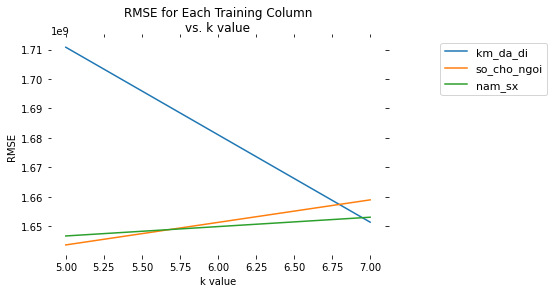

In [19]:
fig, ax = plt.subplots(1)

for key, values in rmse_uni.items():
    ax.plot(k_values, values, label=key)
    ax.set_xlabel('k value')
    ax.set_ylabel('RMSE')
    ax.set_title('RMSE for Each Training Column\nvs. k value')
    ax.tick_params(top="off", left="off", right="off", bottom='off')
    ax.legend(bbox_to_anchor=(1.5, 1), prop={'size': 11})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

In [20]:
# Multivariate model
def knn_train_test(features, target_column, df, k):
    
    # Randomize order of rows in data frame.
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Split the dataset
    train_set = rand_df.iloc[0:int(len(rand_df)/2)]
    test_set = rand_df.iloc[int(len(rand_df)/2):]
    
    # Train
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(train_set[features], train_set[target_column])
    
    # Predict
    predictions = knn.predict(test_set[features])
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test_set[target_column], predictions))
    
    return rmse

In [21]:
avg_rmse = {}

for key, values in rmse_uni.items():
    avg_rmse[key] = np.mean(values)

avg_rmse = pd.Series(avg_rmse)
avg_rmse.sort_values()

nam_sx         1.649859e+09
so_cho_ngoi    1.651283e+09
km_da_di       1.681064e+09
dtype: float64

In [ ]:
columns = data.columns

import re


categories = ['kieu_dang', 'hop_so', 'nhien_lieu', 'tinh_trang', 'xuat_xu', 'dong_xe', 'hang']
total = []

for c in categories:
  p = re.compile(c)
  lis = [ s for s in columns if p.match(s)]
  total.append(lis)

total

In [23]:
features = {
        'kieu_dang': total[0],
        'hop_so': total[1],
        'nhien_lieu': total[2],
        'tinh_trang': total[3],
        'xuat_xu': total[4],
        'dong_xe': total[5],
        'hang': total[6],
    } 

rmse_uti_onehot = {}
target_column = 'gia'
k = 5

for key, value in features.items():
    rmse_uti_onehot[key] = knn_train_test(value, target_column, normal_data, k)
    
pd.Series(rmse_uti_onehot).sort_values()

dong_xe       8.317357e+08
hang          1.186785e+09
hop_so        1.666566e+09
nhien_lieu    1.717788e+09
tinh_trang    1.745475e+09
kieu_dang     1.751900e+09
xuat_xu       1.845813e+09
dtype: float64

In [25]:
type(total[0])

list

In [28]:
data.columns

Index(['km_da_di', 'so_cho_ngoi', 'nam_sx', 'gia', 'tinh_trang_Mới',
       'tinh_trang_Đã sử dụng', 'hang_Acura', 'hang_Alfa Romeo', 'hang_Asia',
       'hang_Audi',
       ...
       'kieu_dang_Van/Minivan', 'kieu_dang_Wagon', 'nhien_lieu_Dầu',
       'nhien_lieu_Hybrid', 'nhien_lieu_Xăng', 'nhien_lieu_Điện',
       'hop_so_Bán tự động', 'hop_so_Số sàn', 'hop_so_Số tay',
       'hop_so_Tự động'],
      dtype='object', length=736)

In [29]:
list_feature_no_price = [i for i in data.columns if i != 'gia']

In [33]:
top_6_feature = [i for i in list_feature_no_price if 'dong_xe' in i or 'hang' in i or 'hop_so' in i or 'km_da_di' in i or 'so_cho_ngoi' in i or 'nam_sx' in i]

In [35]:
# chọn 3 model tốt nhất  ở bên trên để hyperparameter turning k

top_models = {
  'best_2': list_feature_no_price, # tat ca du lieu, 
  'best_3': top_6_feature
}

k_values = list(range(1, 26))
rmse_multi_k = {}
rmse_current = []

for key, value in top_models.items():
    for k in k_values:
        rmse_current.append(knn_train_test(value, target_column, normal_data, k))
        
    rmse_multi_k[key] = rmse_current
    rmse_current = []
    
print(rmse_multi_k)

{'best_2': [625783062.7440116, 520037293.1824435, 502856083.00389105, 520346452.37530136, 541109296.8920982, 567318175.2107397, 587305404.1333499, 600831562.7212863, 602584841.1886667, 589746530.7335424, 594038887.0983719, 598732945.0036383, 602579733.201627, 603938468.1495019, 608956619.2657049, 617181086.2184737, 628282048.3808008, 640003841.6349522, 648933580.0966985, 661911693.2712716, 673207669.1117634, 680874983.8118638, 693653215.4802309, 701559996.0442894, 716319832.4611263], 'best_3': [610222048.6383972, 508056396.72046596, 474298543.14692456, 502601113.73587435, 509698964.6718622, 513705463.4313595, 520201182.18174994, 533291100.2803051, 516109514.79846776, 520372970.3791711, 517632364.9784108, 523433162.7790509, 536903548.9088646, 547342974.1957846, 560001332.9984161, 585024961.1164759, 603553817.8112665, 624979538.120864, 629564687.2663349, 636424524.026442, 646449349.8595083, 657528987.8971713, 659776122.7629926, 659618878.5388644, 660873745.8103235]}


{'best_2': [502856083.00389105, 2], 'best_3': [474298543.14692456, 2]}


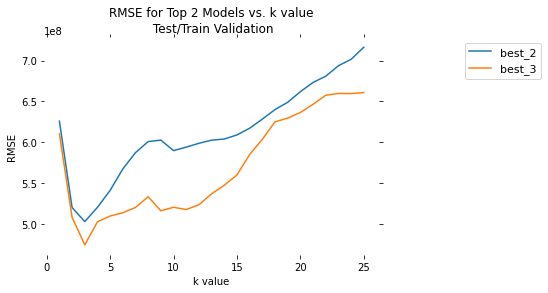

In [37]:
# Returns a dict with the min value of every key's list and its index the list
def min_key_value(dictionary):
    min_values = {}
    for k, v in dictionary.items():
        min_values[k] = [min(v), v.index(min(v))]
        
    return min_values
        
best_k = min_key_value(rmse_multi_k)
print(best_k)

# Plot results
fig, ax = plt.subplots(1)

for key, values in rmse_multi_k.items():
    ax.plot(k_values, values, label=key)
    ax.set_xlabel('k value')
    ax.set_ylabel('RMSE')
    ax.set_title('RMSE for Top 2 Models vs. k value\n Test/Train Validation')
    ax.tick_params(top="off", left="off", right="off", bottom='off')
    ax.legend(bbox_to_anchor=(1.5, 1), prop={'size': 11})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)